In [147]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.neighbors import KNeighborsClassifier
import random
from datetime import datetime
import itertools


In [164]:
def findsubsets(S,m):
    return set(itertools.combinations(S, m))

In [225]:
def pra_metrics(pred, actual):
    pred = list(pred)
    actual = list(actual)
    acc = np.mean([int(i==j) for (i,j) in zip(pred,actual)])
    true_pos = sum([int(i==1 and j==1) for (i,j) in zip(pred,actual)])
    false_neg = sum([int(i==0 and j==1) for (i,j) in zip(pred,actual)])
    false_pos = sum([int(i==1 and j==0) for (i,j) in zip(pred,actual)])
    prec = float(true_pos)/(true_pos + false_pos)
    rec = float(true_pos)/(true_pos + false_neg)
    return(prec, rec, acc)
    

In [165]:
feature_df = pd.read_csv('feature_table.csv')

In [166]:
samp_feature_df = feature_df.sample(frac=10000/float(len(feature_df)))
drops_out_list = samp_feature_df.drops_out_in_next_year

In [226]:
norms = ['euclidean', 'cityblock', 'minkowski', 'canberra', 'hamming']
feats = ['is_male', 'alph_term', 'units_so_far', 'terms_so_far', 'running_gpa', 'quarter_count', 'gpa_last_quarter']

kept_k = [10*i+1 for i in range(10,100)]
kept_s = [0.6,0.7,0.8,0.9]
kept_norms = norms
kept_feats = list(findsubsets(feats, 2)) + list(findsubsets(feats, 4)) + list(findsubsets(feats, 7))

random.shuffle(norms)
random.shuffle(kept_s)
random.shuffle(kept_k)


model_store = []

round_length = 100
lim = int(round_length*0.1)
model_times = []

start = datetime.now()
round = 0
while((len(kept_norms)>1 or len(kept_k)>1 or len(kept_s)>1 or len(kept_feats)>1) and round<10):
    for c in range(round_length):
        
        s = random.choice(kept_s)
        k = random.choice(kept_k)
        norm = random.choice(kept_norms)
        feat_choice = list(random.choice(kept_feats))
        
        lim_feature_df = samp_feature_df[feat_choice]
        lim_feat_mtx = lim_feature_df.as_matrix()
        
        cutoff = int((len(lim_feat_mtx)*s))
        begin_model = datetime.now()
        neigh = KNeighborsClassifier(n_neighbors=k, metric=norm)
        neigh.fit(lim_feat_mtx[:cutoff], drops_out_list[:cutoff])
        pred_vals = neigh.predict(lim_feat_mtx[cutoff:])
        model_times.append((datetime.now() - begin_model).total_seconds())
        metrics = pra_metrics(pred_vals, drops_out_list[cutoff:])
        model_store.append((k, s, norm, feat_choice, metrics[0], metrics[1], metrics[2]))
        
    model_store = sorted(model_store, key=lambda x: -x[6])
    kept_k = list(set([i[0] for i in model_store][:lim]))
    kept_s = list(set([i[1] for i in model_store][:lim]))
    kept_norms = list(set([i[2] for i in model_store][:lim]))
    end_f_list = [i[3] for i in model_store][:lim]
    kept_feats = list(end_f_list for end_f_list,_ in itertools.groupby(end_f_list))
    print 'Best This Round: ', model_store[0]
    print kept_k, kept_s, kept_norms, kept_feats
    model_store = []
    round += 1
tot_time = (datetime.now() - start).total_seconds()
print tot_time
print 'Avg model time: ', np.mean(model_times)
    
    
    

Best This Round:  (261, 0.9, 'minkowski', ['is_male', 'units_so_far'], 0.8897379912663755, 0.9795673076923077, 0.88200000000000001)
[161, 771, 261, 321, 201, 381, 371, 501, 251, 541] [0.7, 0.9, 0.6, 0.8] ['minkowski', 'cityblock', 'canberra', 'euclidean'] [['is_male', 'units_so_far'], ['units_so_far', 'terms_so_far'], ['is_male', 'units_so_far', 'quarter_count', 'gpa_last_quarter'], ['units_so_far', 'terms_so_far', 'quarter_count', 'gpa_last_quarter'], ['is_male', 'units_so_far', 'quarter_count', 'gpa_last_quarter'], ['alph_term', 'units_so_far'], ['units_so_far', 'running_gpa'], ['is_male', 'units_so_far', 'terms_so_far', 'quarter_count'], ['units_so_far', 'terms_so_far', 'running_gpa', 'gpa_last_quarter'], ['units_so_far', 'gpa_last_quarter']]
Best This Round:  (161, 0.8, 'minkowski', ['units_so_far', 'terms_so_far'], 0.9073869900771775, 0.9803454437164979, 0.89949999999999997)
[371, 161, 251, 381, 201] [0.9, 0.6, 0.8] ['minkowski', 'cityblock', 'canberra', 'euclidean'] [['units_so_f

In [146]:
norms = ['euclidean', 'cityblock', 'minkowski', 'canberra', 'hamming']

kept_k = [10*i+1 for i in range(10,100)]
kept_s = [0.6,0.7,0.8,0.9]
kept_norms = norms

best_so_far = 0



start = datetime.now()
for norm in norms:
    for k in kept_k:
        for s in kept_s:
        
            cutoff = int((len(lim_feat_mtx)*s))
            neigh = KNeighborsClassifier(n_neighbors=k, metric=norm)
            neigh.fit(lim_feat_mtx[:cutoff], drops_out_list[:cutoff])
            pred_vals = neigh.predict(lim_feat_mtx[cutoff:])
            acc = np.mean([i==j for (i,j) in zip(pred_vals, drops_out_list[cutoff:])])
            if acc > best_so_far:
                best_so_far = acc
                print norm, k, s, acc
                print (datetime.now()-start).total_seconds()
                print '-----------------------'
    
    
    

euclidean 101 0.6 0.862
0.261
-----------------------
euclidean 101 0.7 0.866666666667
0.439
-----------------------
euclidean 101 0.8 0.8705
0.624
-----------------------
euclidean 121 0.8 0.8715
2.133
-----------------------


KeyboardInterrupt: 

In [239]:
norm = 'canberra'

k_list = [10*i+1 for i in range(10,100)]
s=.8
kept_norms = norms

k_tups = []

lim_feature_df = samp_feature_df[['units_so_far', 'terms_so_far']]
lim_feat_mtx = lim_feature_df.as_matrix()

for k in k_list:
    cutoff = int((len(lim_feat_mtx)*s))
    neigh = KNeighborsClassifier(n_neighbors=k, metric=norm)
    neigh.fit(lim_feat_mtx[:cutoff], drops_out_list[:cutoff])
    pred_vals = neigh.predict(lim_feat_mtx[cutoff:])
    k_tups.append((k, pra_metrics(pred_vals, drops_out_list[cutoff:])))

    
    

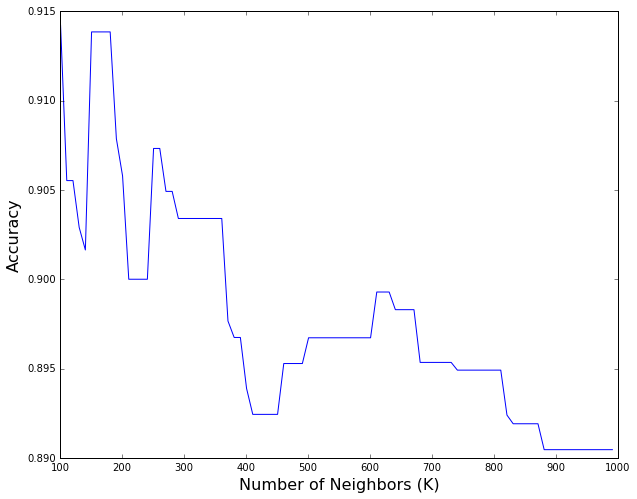

In [248]:
plt.clf()
plt.figure(figsize=(10,8))
k_vals = [i[0] for i in k_tups]
acc_vals = [i[1][0] for i in k_tups]
prec_vals = [i[1][1] for i in k_tups]
rec_vals = [i[1][2] for i in k_tups]
plt.plot(k_vals, acc_vals)
#plt.plot(k_vals, prec_vals)
#plt.plot(k_vals, rec_vals)
plt.xlabel('Number of Neighbors (K)', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.savefig('k_acc_plot.png')

In [94]:
#baseline

p = np.mean(drops_out_list)
print 'Raw Proportion:', p
print 'Random Guessing:', p**2 + (1-p)**2

Raw Proportion: 0.8403
Random Guessing: 0.73160818


euclidean
cityblock
minkowski
euclidean


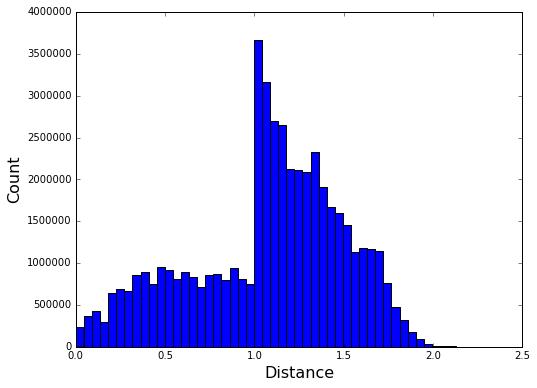

---------------
cityblock


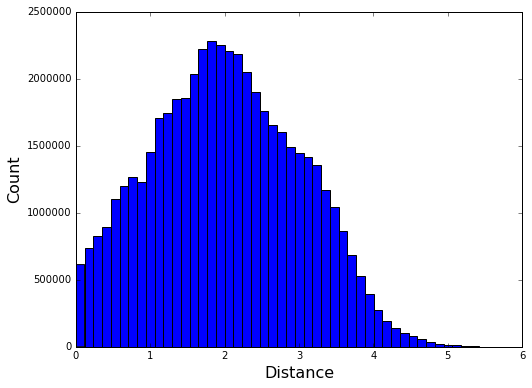

---------------
minkowski


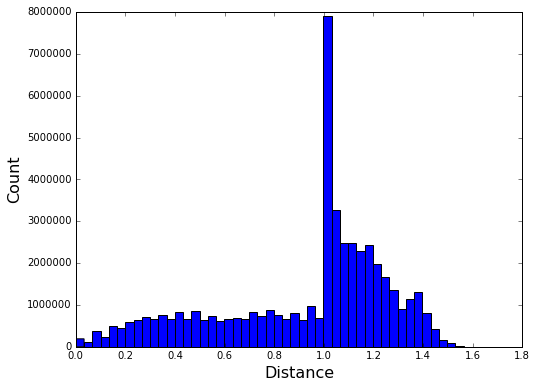

---------------


In [230]:
lim_feature_df = samp_feature_df[feats]
lim_feat_mtx = lim_feature_df.as_matrix()
    
Y_dict = {}
dist_dict = {}

for norm in ['euclidean', 'cityblock', 'minkowski']:
    print norm
    if norm == 'minkowski':
        Y_dict[norm] = pdist(lim_feat_mtx, norm, 3)
    else:
        Y_dict[norm] = pdist(lim_feat_mtx, norm)
    

for norm in ['euclidean', 'cityblock', 'minkowski']:
    plt.clf()
    plt.figure(figsize=(8,6))
    print norm
    plt.hist(Y_dict[norm], bins=50)
    plt.xlabel('Distance', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.savefig(norm+'_distr.png')
    plt.show()
    print '---------------'

# KNN 

# Error Analysis

In [176]:
lim_feature_df = samp_feature_df[['units_so_far', 'terms_so_far']]
lim_feat_mtx = lim_feature_df.as_matrix()

cutoff = int((len(lim_feat_mtx)*.8))
neigh = KNeighborsClassifier(n_neighbors=211, metric='minkowski')
neigh.fit(lim_feat_mtx[:cutoff], drops_out_list[:cutoff])
pred_vals = neigh.predict(lim_feat_mtx[cutoff:])

In [179]:
wrong_ind = []
for i, tup in enumerate(zip(pred_vals, drops_out_list[cutoff:])):
    if sum(tup) == 1:
        wrong_ind.append(i)

In [194]:
test_df = samp_feature_df[cutoff:]
test_df['ind'] = range(len(test_df))
wrong_df = test_df[test_df.ind.isin(wrong_ind)]

C:\Users\Ritvik\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [201]:
sum(wrong_df.Gender == 'M')/float(len(wrong_df)), sum(feature_df.Gender == 'M')/float(len(feature_df))

(0.59223300970873782, 0.54130494187879674)

In [208]:
sum(wrong_df.USresident == 'R')/float(len(wrong_df)), sum(feature_df.USresident == 'R')/float(len(feature_df))

(0.76213592233009708, 0.89822483341391124)

In [204]:
np.mean(wrong_df.running_gpa), np.mean(feature_df.running_gpa)

(0.1506064222664222, -1.3933129326405137e-13)

In [206]:
np.mean(wrong_df.units_so_far), np.mean(feature_df.units_so_far)

(0.03952281709263871, 1.0463559124596587e-14)

In [207]:
feature_df

,Unnamed: 0,shortKey,ID,Term,MajorCode,Classification,ResTuit,Gender,AdmitClass,EthnicityCode,USresident,is_male,alph_term,units_so_far,terms_so_far,running_gpa,quarter_count,gpa_last_quarter,drops_out_in_next_year
0,0,0000200d607da1bd8ea52eb48c32b44b32d726b622c9e8...,0x8862C232D0C780013C83CCCC6962C41FBFE74DC2,00F,193,UFR,R,M,UFR,WH,R,0.458695,-0.480154,-0.068032,-0.103104,-0.483614,-0.103104,-0.476687,1
1,1,000093735b6a3375f15c1fe7637330957e099751f89c7f...,0xF6CFA9EA21680AA98CE09972CF0BAC1F330D8E8B,05F,303,USR,R,M,UJR,CA,R,0.458695,-0.141171,-0.036782,-0.044281,-0.294935,-0.044281,-0.288008,1
2,2,000109bf56d6391acf3869b3735966f1c3561fddb6f207...,0x4F5A4FD604103B643670F731D982264F4669BAC2,12W,153,USO,N,F,UFR,WH,N,-0.541305,0.282557,0.056968,0.132190,0.299405,0.132190,0.334633,1
3,3,00011befdc16ce447177f612c6801c82ca0918ba3b05c4...,0x6378CE354D056F16379C3286FEA5416D9141953F,05W,193,USO,R,M,UFR,CA,R,0.458695,-0.192019,-0.036782,-0.044281,0.082424,-0.044281,0.089350,1
4,4,000167660de678d7f32fc80f9945ddef98f0513f241f02...,0x4872CC43ED5F6CE6DC238EFB650FB3CD24CB6077,07W,336,UFR,R,M,UFR,,R,0.458695,-0.056426,-0.036782,-0.044281,0.327707,-0.044281,0.334633,1
5,5,000208a074e0dee44eac86c3c8fa354d855fd5b75a7566...,0x6931D539AED046A9A563DAE0AAD62483AB055DF0,06W,300,USO,R,M,UFR,LA,R,0.458695,-0.124222,0.056968,0.132190,0.190914,0.132190,0.089350,1
6,6,0002242f56ef94b64a51d4d3523ebf4322db5efbff1c3d...,0xD8318E148FCC2C595A92973D36AF1526DE7B3A22,04S,0,UJR,R,M,USO,WH,R,0.458695,-0.242866,-0.005532,0.014543,0.459782,0.014543,0.466709,1
7,7,0002b64ee3bd88263c06d853e8cdaf594f41eed5f7e07b...,0x3FDEDEB6F1D26298205CC5A2D9B9562168169244,02W,0,UJR,R,M,UFR,PI,R,0.458695,-0.395409,-0.005532,0.014543,0.025820,0.014543,0.221426,1
8,8,00033320768e1939d1bb8de37ef76fb05771f8e2c51cdf...,0x9E30336B5AB6F38DB5889CC07A3885C4118C81FA,08F,72,USO,N,F,USO,MA,R,-0.541305,0.062218,-0.068032,-0.103104,-0.483614,-0.103104,-0.476687,0
9,9,000350044993a2a51ee59e9dd2efe5f384b9a2fbf59197...,0x40386B4691D233C5275F70447ACE8DFD1CF4EBB7,01W,201,USO,R,M,UFR,WH,R,0.458695,-0.463205,0.025718,0.073366,0.126449,0.073366,0.089350,1
